In [4]:
#3
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr

training = pd.read_csv('Housing Data/train.csv')
testing = pd.read_csv('Housing Data/test.csv')

%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

training.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1034aa780>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1a0b010f98>]], dtype=object)

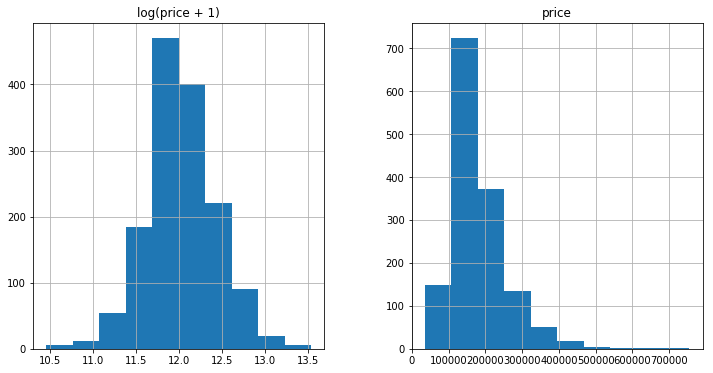

In [5]:
all_data = pd.concat((training.loc[:,'MSSubClass':'SaleCondition'],
                      testing.loc[:,'MSSubClass':'SaleCondition']))

matplotlib.rcParams['figure.figsize'] = (12.0, 6.0)

#showing the difference after normalization vs pre-normalization
prices = pd.DataFrame({"price":training["SalePrice"], "log(price + 1)":np.log1p(training["SalePrice"])})
prices.hist()

In [6]:
#normalize the data
training['SalePrice'] = np.log1p(training['SalePrice'])

#transform the numeric features
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = training[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness of each feature
skewed_feats = skewed_feats[skewed_feats > 0.75] #features with skew greater than a value of 0.75
skewed_feats = skewed_feats.index #get the index of these feautures

all_data[skewed_feats] = np.log1p(all_data[skewed_feats]) #all skewed features are normalized
all_data = pd.get_dummies(all_data) # turn the categorical values into indicator variables
all_data = all_data.fillna(all_data.mean())

all_data.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,4.110874,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,3.044522,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,4.110874,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4.262680,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,4.110874,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


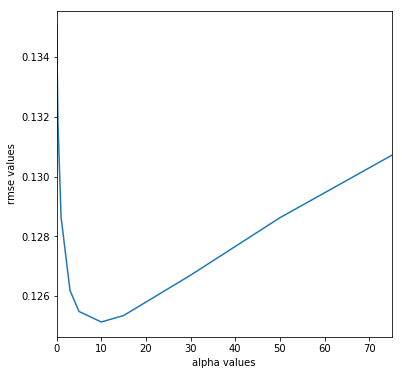

0.125137750113


In [41]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

#split the training data into train and testing
x_train = all_data[:training.shape[0]]
x_test = all_data[training.shape[0]:]
y = training.SalePrice

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y, scoring="neg_mean_squared_error", cv = 10))
    return(rmse)

alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75] #making a list of alphas to choose from
model_ridge = Ridge() #using the ridge model
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.xlabel("alpha values")
plt.ylabel("rmse values")
plt.show()

print(cv_ridge.min())

In [42]:
#3 continued
#making a model using an alpha of 10
ridge = Ridge(10)
ridge_model = ridge.fit(x_train, y)
ridge_preds = np.expm1(ridge_model.predict(x_test))

solution = pd.DataFrame({"id":testing.Id, "SalePrice":ridge_preds})
solution.to_csv("ridge_sol_new.csv", index = False)

In [46]:
#3 continued... trying to improve the model
#using the lassos regression model
lassos = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], max_iter=1e5).fit(x_train, y)
coef = pd.Series(lassos.coef_, index=x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")


Lasso picked 110 variables and eliminated the other 178 variables


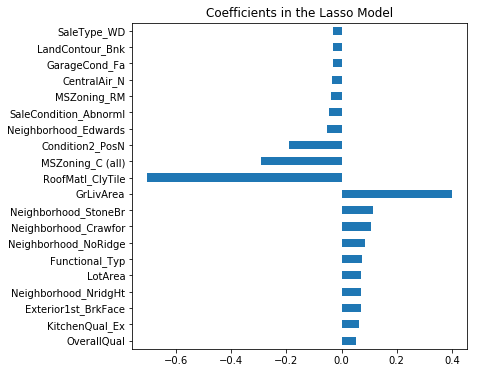

In [47]:
imp_coef = pd.concat([coef.sort_values().tail(10),
                     coef.sort_values().head(10)])


imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [48]:
#making predictions using lassos
prediction = lassos.predict(x_test)
solution = pd.DataFrame({"id":testing.Id, "SalePrice":prediction})
solution.to_csv("lassos_solution.csv", index = False)